In [1]:
import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import LambdaLR
from utils import Logger
from utils import weights_init_normal
from datasets import ImageDataset

In [2]:
# import visdom
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy import ndimage, optimize
import pdb 
import cv2
import matplotlib.patches as patches
import multiprocessing
import datetime
from tqdm import tqdm_notebook

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
from itertools import product
from extractRect import *
from torch import Tensor
from torchsummary import summary

In [75]:
nsh = np.shape
def set_all_rcParams(true_or_false):
    rcParams['ytick.left']=true_or_false
    rcParams['xtick.bottom']=true_or_false
    rcParams['ytick.labelleft'] = true_or_false
    rcParams['xtick.labelbottom'] = true_or_false

In [6]:
torch.cuda.set_device(1)

In [7]:
epoch=0
n_epochs = 10 #original 200
batchsize=1 # original 1
lr=0.0002
decay_epoch = 5 # original 100
size=128
input_nc = 1 # original 3
output_nc = 1 # original 3
cuda = True

In [8]:
# parser = argparse.ArgumentParser()
# epoch = 0
# n_epochs = 10 #original 200
# batchSize = 1
# dataroot = 'dataset/'
# lr = 0.0002
# decay_epoch = 5 # original 100
# size = 256
# input_nc = 1 # original 1
# output_nc = 1 # original 1
# cuda = False
# n_cpu = 2

In [9]:
# dataroot='datasets
# cuda='use GPU computation')
# n_cpu=8

In [10]:
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

In [11]:
if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

In [12]:
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

/home/om18/Documents/KCL/Feb 20 19 - CycleGan clean/PyTorch-CycleGAN/utils.py:114: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [13]:
summary(netG_A2B, (input_nc,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 1, 134, 134]               0
            Conv2d-2         [-1, 64, 128, 128]           3,200
    InstanceNorm2d-3         [-1, 64, 128, 128]               0
              ReLU-4         [-1, 64, 128, 128]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-6          [-1, 128, 64, 64]               0
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         295,168
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
             ReLU-10          [-1, 256, 32, 32]               0
  ReflectionPad2d-11          [-1, 256, 34, 34]               0
           Conv2d-12          [-1, 256, 32, 32]         590,080
   InstanceNorm2d-13          [-1, 256, 32, 32]               0
             ReLU-14          [-1, 256,

In [14]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [15]:
# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

In [16]:
path_source = '/data/OMM/Datasets/data for inpainting GANs/slices inpainting v7/'

In [17]:
files = os.listdir(f'{path_source}/orig')
files = np.sort(files)

In [18]:
fold = 1
files_train, files_test = train_test_split(files, test_size=0.2, random_state=fold)

In [42]:
class LIDCGAN_dataready(Dataset):
    def __init__(self, files_train_test, box_gan_size = 128, transform = False):
        self.A = [f'{path_source}orig/{i}' for i in files_train]
        self.B = [f"{path_source}last/{i.replace('orig ','last ')}" for i in files_train_test]
        self.transform = transform
        
    def __len__(self):
        return len(self.A)
    
    def flips(self, image1, image2):
        if np.random.rand() > .5:
            image1 = np.flip(image1,0).copy()
            image2 = np.flip(image2,0).copy()
        if np.random.rand() > .5:
            image1 = np.flip(image1,1).copy()
            image2 = np.flip(image2,1).copy()
        return image1, image2
                              
    def __getitem__(self, idx):
        
        imgA = np.load(self.A[idx])
        imgB = np.load(self.B[idx])
        
        # Flips
        imgA, imgB = self.flips(imgA, imgB)
                    
        # Add channels dimension
        imgA = np.expand_dims(imgA,0)
        imgB = np.expand_dims(imgB,0)
        
        #
        imgA = Tensor(imgA)
        imgB = Tensor(imgB)
                  
        # Get name to save the data                      
        name = self.A[idx].split('orig/')[-1]
                              
        return imgA, imgB, name

In [94]:
dataset_train = LIDCGAN_dataready(files_train, box_gan_size=128, transform=True)

In [95]:
dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=False)

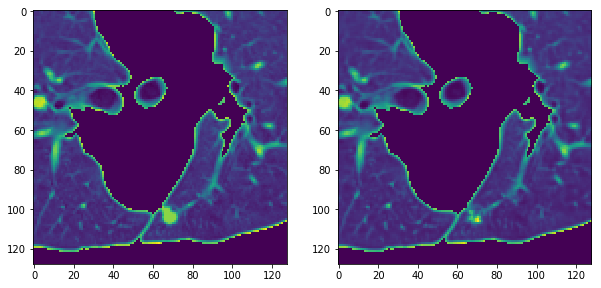

In [22]:
a, b = next(iter(dataloader_train))
for i,j in zip(a,b):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    i = i[0].detach().cpu().numpy()
    j = j[0].detach().cpu().numpy()
    ax[0].imshow(i)
    ax[1].imshow(j)

In [23]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchsize, input_nc, size, size)
input_B = Tensor(batchsize, input_nc, size, size)
target_real = Variable(Tensor(batchsize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchsize).fill_(0.0), requires_grad=False)

In [24]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [26]:
path_netG_A2B = '../GAN results/v1/netG_A2B.pth'
path_netG_B2A = '../GAN results/v1/netG_B2A.pth'
path_netD_A = '../GAN results/v1/netD_A.pth'
path_netD_B = '../GAN results/v1/netD_B.pth'

In [ ]:
def save_generated_images(real_A_allX, real_B_allX, fake_A_allX, fake_B_allX, real_AX, real_BX, fake_AX, fake_BX):
    real_A_allX.append(real_AX)
    real_B_allX.append(real_BX)
    fake_A_allX.append(fake_AX)
    fake_B_allX.append(fake_BX)

In [101]:
loss_G_all = []
loss_G_identity_all = []
loss_G_GAN_all = []
loss_G_cycle_all = []
loss_D_all = []
# some images to watch
real_A_all1, real_A_all2, real_A_all3, real_A_all4, real_A_all5 = [], [], [], [], []
real_B_all1, real_B_all2, real_B_all3, real_B_all4, real_B_all5 = [], [], [], [], []
fake_A_all1, fake_A_all2, fake_A_all3, fake_A_all4, fake_A_all5 = [], [], [], [], []
fake_B_all1, fake_B_all2, fake_B_all3, fake_B_all4, fake_B_all5 = [], [], [], [], []
name_watch1 = 'LIDC-IDRI-0045_nodule_011.npy'
name_watch2 = 'LIDC-IDRI-0060_nodule_002.npy'
name_watch3 = 'LIDC-IDRI-0158_nodule_003.npy'
name_watch4 = 'LIDC-IDRI-0042_nodule_003.npy'
name_watch5 = 'LIDC-IDRI-0164_nodule_006.npy'

###### Training ######
for epoch in tqdm_notebook(range(epoch, n_epochs)):
    if epoch==1:break
    print(f'epoch = {epoch}')
    for i, (A, B, name) in tqdm_notebook(enumerate(dataloader_train), total= dataloader_train.dataset.__len__() // batchsize):
        # Set model input
        real_A = Variable(input_A.copy_(A))
        real_B = Variable(input_B.copy_(B))
        #pdb.set_trace()
        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        pred_fake.squeeze_() # OMM
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        pred_fake.squeeze_() # OMM
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        pred_real.squeeze_() # OMM
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        pred_fake.squeeze_() # OMM
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        pred_real.squeeze_() # OMM
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        pred_fake.squeeze_() # OMM
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        
        # Save results
        loss_G_all.append(loss_G.detach().cpu().numpy())
        loss_G_identity_all.append((loss_identity_A.detach().cpu().numpy() + loss_identity_B.detach().cpu().numpy()))
        loss_G_GAN_all.append((loss_GAN_A2B.detach().cpu().numpy() + loss_GAN_B2A.detach().cpu().numpy()))
        loss_G_cycle_all.append((loss_cycle_ABA.detach().cpu().numpy() + loss_cycle_BAB.detach().cpu().numpy()))
        loss_D_all.append((loss_D_A.detach().cpu().numpy() + loss_D_B.detach().cpu().numpy()))
        
        # Save generated images (from a few examples)
        
        if name[0] == name_watch1: save_generated_images(real_A_all1, real_B_all1, fake_A_all1, fake_B_all1, real_A, real_B, fake_A, fake_B)
        if name[0] == name_watch2: save_generated_images(real_A_all2, real_B_all2, fake_A_all2, fake_B_all2, real_A, real_B, fake_A, fake_B)
        if name[0] == name_watch3: save_generated_images(real_A_all3, real_B_all3, fake_A_all3, fake_B_all3, real_A, real_B, fake_A, fake_B)
        if name[0] == name_watch4: save_generated_images(real_A_all4, real_B_all4, fake_A_all4, fake_B_all4, real_A, real_B, fake_A, fake_B)
        if name[0] == name_watch5: save_generated_images(real_A_all5, real_B_all5, fake_A_all5, fake_B_all5, real_A, real_B, fake_A, fake_B)
    

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), path_netG_A2B)
    torch.save(netG_B2A.state_dict(), path_netG_B2A)
    torch.save(netD_A.state_dict(), path_netD_A)
    torch.save(netD_B.state_dict(), path_netD_B)

epoch = 9


In [98]:
print(name[0])
print(name[0])
print(name[0])
print(name[0])
print(name[0])

'LIDC-IDRI-0013_nodule_002.npy'

In [108]:
len(fake_B_all1)

1

In [105]:
aa = [i.detach().cpu().numpy()[0][0] for i in fake_B_all1]

In [107]:
nsh(aa)

(1, 128, 128)

In [90]:
import imageio

In [106]:
imageio.mimsave(f'{path_test_output}B/fake_B_all1.gif',aa)

In [34]:
path_netG_A2B

'../GAN results/v1/netG_A2B.pth'

# Test

In [49]:
path_test_output = '../GAN results/v1/test output/'

In [50]:
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)

if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()

In [51]:
# Load state dicts
netG_A2B.load_state_dict(torch.load(path_netG_A2B))
netG_B2A.load_state_dict(torch.load(path_netG_B2A))

In [52]:
# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256,

In [53]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchsize, input_nc, size, size)
input_B = Tensor(batchsize, output_nc, size, size)

In [54]:
dataset_test = LIDCGAN_dataready(files_test, box_gan_size=128, transform=True)

In [55]:
dataloader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=False)

In [56]:
for i, (A, B, name) in enumerate(dataloader_test):
    # Set model input
    real_A = Variable(input_A.copy_(A))
    real_B = Variable(input_B.copy_(B))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save output
    np.save(f'{path_test_output}A/{name[0]}', fake_A)
    np.save(f'{path_test_output}B/{name[0]}', fake_B)

# View results

In [60]:
files_generated = os.listdir(f'{path_test_output}A')

In [62]:
ff = files_generated[0]

In [72]:
genA = np.load(f'{path_test_output}A/{ff}')
genB = np.load(f'{path_test_output}B/{ff}')
origA = np.load(f'{path_source}orig/{ff}')
origB = np.load(f'{path_source}last/{ff}')

In [73]:
nsh(origA)

(128, 128)

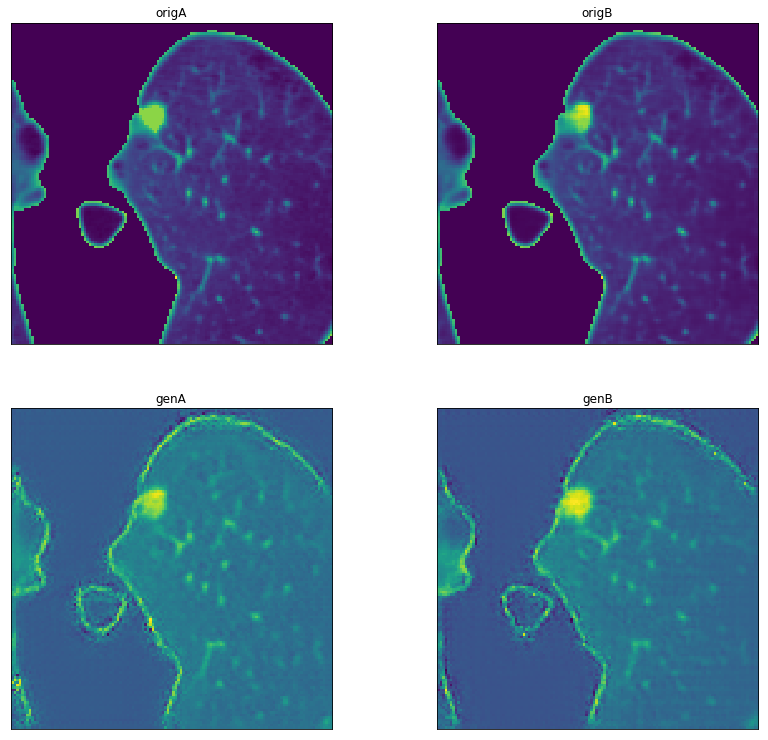

In [85]:
set_all_rcParams(False)
fig, ax = plt.subplots(2,2,figsize=(14,13))
ax[0,0].imshow(origA)
ax[0,0].set_title('origA')
ax[0,1].imshow(origB)
ax[0,1].set_title('origB')
ax[1,0].imshow(genA[0][0])
ax[1,0].set_title('genA')
ax[1,1].imshow(genB[0][0])
ax[1,1].set_title('genB')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

# Old Functions

In [58]:
# def adjust_rect_to_size(self, box_gan_size, xx1,xx2,yy1,yy2):
#     '''Adjust the rect coords to crop or pad the image to obtain the desired size.
#     Depending on the coords we crop/pad on top or bottom and on left or right'''
#     pad_or_crop_0 = box_gan_size-(xx2-xx1)
#     pad_or_crop_1 = box_gan_size-(yy2-yy1)
#     if pad_or_crop_0 > 0: # pad
#         if xx2 > 200: # pad to the left
#             xx1 = xx1 - pad_or_crop_0
#         else: # pad to the right
#             xx2 = xx2 + pad_or_crop_0
#     else:
#         if xx2 > 200: #crop left
#             xx2 = xx2 + pad_or_crop_0
#         else: # crop right
#             xx1 = xx1 - pad_or_crop_0

#     if pad_or_crop_1 > 0: #pad
#         if yy2 > 200: # pad top
#             yy1 = yy1 - pad_or_crop_1
#         else: # pad below
#             yy2 = yy2 + pad_or_crop_1
#     else: #crop
#         if yy2 > 200: #crop below
#             yy2 = yy2 + pad_or_crop_1
#         else: # crop top
#             yy1 = yy1 - pad_or_crop_1
#     return xx1,xx2,yy1,yy2

In [59]:
# def adjust_rect_to_size(self, box_gan_size, x1,x2,y1,y2):
#     # Check the dimensions of the rect found and see if we need to pad or crop (poc)
#     poc_0 = box_gan_size-(x2-x1)
#     poc_1 = box_gan_size-(y2-y1)
#     poc_0_half = poc_0//2 # Add up to poc_0_half to each direction
#     poc_1_half = poc_1//2

#     # Correction for images with odd dimensions
#     if poc_0 % 2 == 0: odd_0 = 0 
#     else: odd_0 = 1
#     if poc_1 % 2 == 0: odd_1 = 0 
#     else: odd_1 = 1

#     if poc_0 > 0: # pad
#         if x2 + poc_0_half < np.shape(imgA)[1] and x1 - poc_0_half > 0: #padboth
#             x1 = x1 - poc_0_half
#             x2 = x2 + poc_0_half - odd_0

#         elif x2 + poc_0_half < np.shape(imgA)[1]: # pad to the right
#             x2 = x2 + poc_0
#         else:
#             x1 = x1 - poc_0 #pad to the left
#     else: # crop
#         if (x2 - poc_0_half) - x_max > 0 and (x1 + poc_0_half) - x_min > 0:
#             x1 = x1 + poc_0_half
#             x2 = x2 - poc_0_half + odd_0
#         elif (x2 - poc_0_half) - x_max > 0: # crop right
#             x2 = x2 - poc_0
#         else: # crop left
#             x1 = x1 + poc_0

#     if poc_1 > 0: # pad
#         if y2 + poc_1_half < np.shape(imgA)[0] and y1 - poc_1_half > 0: #padboth
#             y1 = y1 - poc_1_half
#             y2 = y2 + poc_1_half - odd_1

#         elif y2 + poc_1_half < np.shape(imgA)[0]: # pad to the right
#             y2 = y2 + poc_1
#         else:
#             y1 = y1 - poc_1 #pad to the left
#     else: # crop
#         if (y2 - poc_1_half) - y_max > 0 and (y1 + poc_1_half) - y_min > 0:
#             y1 = y1 + poc_1_half
#             y2 = y2 - poc_1_half + odd_1
#         elif (y2 - poc_1_half) - x_max > 0: # crop right
#             y2 = y2 - poc_1
#         else: # crop left
#             y1 = y1 + poc_1
#     return x1, x2, y1, y2